In [5]:
import tifffile as tiff
from octvision3d.utils import get_filenames
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
# Function to convert hex to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

In [7]:
path = "/home/mstudxk5/Desktop/imagesTs"
label_path = "/home/mstudxk5/Desktop/labelsTs"

# color_map = {
#     1: "#80ae80",  # CNV
#     2: "#f1d691",  # DRU
#     3: "#b17a65",  # EX
#     4: "#6fb8d2",  # FLU
#     5: "#d8654f",  # GA
#     6: "#dd8265",  # HEM
#     7: "#90ee90",  # RPE
#     8: "#a200ff",  # RET
#     9: "#8f8f70",  # CHO
#     10: "#e1f0fd", # VIT
#     11: "#75fafd", # HYA
#     12: "#b0fdd1", # SHS
#     13: "#fdfd54", # ART
#     14: "#387df8", # ERM
#     15: "#643200", # SES
# }

color_map = {
    1: "#90ee90",  # RPE
    2: "#a200ff",  # RET
    3: "#8f8f70",  # CHO
    4: "#e1f0fd", # VIT
    5: "#75fafd", # HYA
    6: "#b0fdd1", # SHS
    7: "#fdfd54", # ART
}

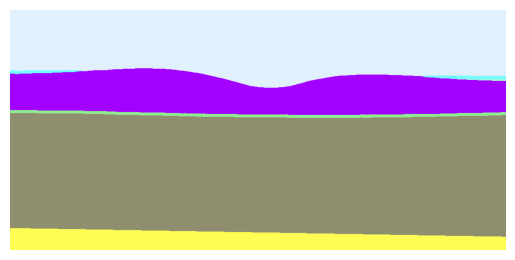

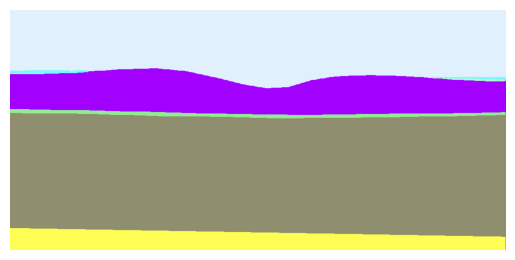

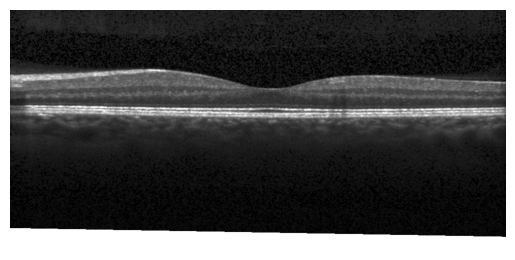

In [16]:
for f in get_filenames(path, "tif")[4:]:
    pred_f = os.path.join(os.path.dirname(f), "predicted", "_".join(os.path.basename(f).split("_")[:-1])+".tif")
    label_f = os.path.join(label_path, "_".join(os.path.basename(f).split("_")[:-1])+".tif")

    pred = tiff.imread(pred_f)
    orig = tiff.imread(f)
    label = tiff.imread(label_f)

    # Create an empty color image with shape (z, y, x, 3) for RGB channels
    z, y, x = orig.shape
    color_pred = np.zeros((z, y, x, 3), dtype=np.uint8)
    color_label = np.zeros((z, y, x, 3), dtype=np.uint8)

    # Map the grayscale image to the color image
    for grayscale_value, hex_color in color_map.items():
        rgb_color = hex_to_rgb(hex_color)
        color_pred[pred == grayscale_value] = rgb_color
        color_label[label == grayscale_value] = rgb_color

    plt.axis("off")
    plt.imshow(color_pred[9])
    plt.show()
    plt.axis("off")
    plt.imshow(color_label[9])
    plt.show()
    plt.axis("off")
    plt.imshow(orig[9], cmap="gray")
    plt.show()

    break